## Import libraries

In [3]:
accesibilidad_urbana = "../../../"

In [84]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

# Para obtener el punto central de una línea en los tests
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [43]:
input_path = accesibilidad_urbana + "data/external/volvo/input_tessellations_network/"
projection_crs = "EPSG:32618"

## Load data

In [8]:
tessellations_nodes = gpd.read_file(input_path + "moravia_LH_tessellations_edited_nodes.shp")

# Show
print(tessellations_nodes.shape)
tessellations_nodes.head(2)

(1198, 2)


,osmid,geometry
0,0,POINT (-75.56627 6.25928)
1,1,POINT (-75.56603 6.26080)


In [9]:
tessellations_edges = gpd.read_file(input_path + "moravia_LH_tessellations_edited_edges.shp")

# Show
print(tessellations_edges.shape)
tessellations_edges.head(2)

(1855, 4)


,u,v,key,geometry
0,0,1,0,"LINESTRING (-75.56627 6.25928, -75.56621 6.259..."
1,0,277,0,"LINESTRING (-75.56627 6.25928, -75.56634 6.259..."


<Axes: >

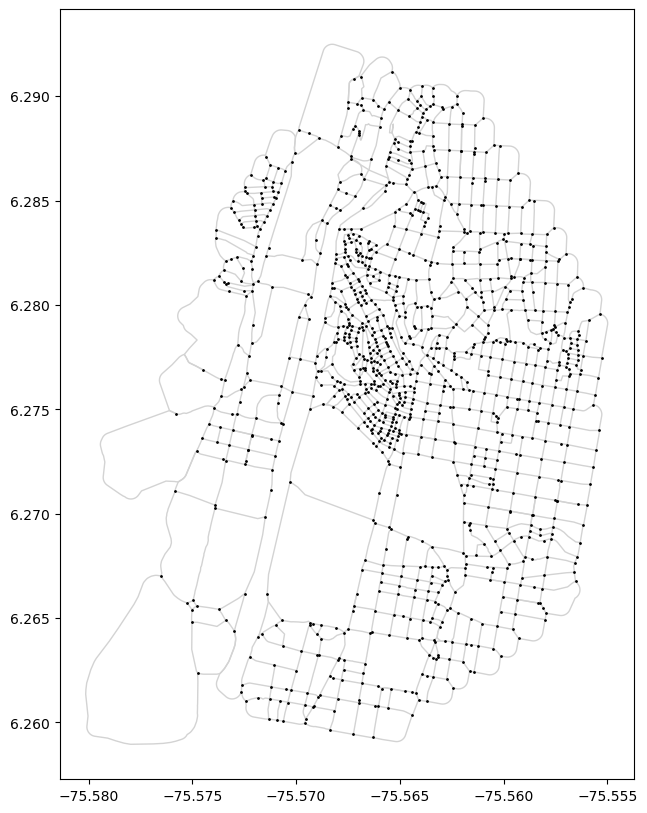

In [28]:
# Show plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
tessellations_nodes.plot(ax=ax,zorder=1,color='black',markersize=1)
tessellations_edges.plot(ax=ax,zorder=0,color='lightgrey',linewidth=1)

## Identify nodes used only by two edges 
##### (Those are not intersections, they should be a single line)

In [37]:
u_list = list(tessellations_edges.u)
v_list = list(tessellations_edges.v)

for osmid in list(tessellations_nodes.osmid.unique()):
    
    found_count = 0
    
    for u in u_list:
        if osmid == u:
            found_count+=1

    for v in v_list:
        if osmid == v:
            found_count+=1

    idx = tessellations_nodes.osmid == osmid
    tessellations_nodes.loc[idx,'found_count'] = found_count

# Show
print(tessellations_nodes.shape)
tessellations_nodes.head(5)

(1198, 3)


,osmid,geometry,found_count
0,0,POINT (-75.56627 6.25928),3.0
1,1,POINT (-75.56603 6.26080),4.0
2,277,POINT (-75.56724 6.25944),3.0
3,2,POINT (-75.56558 6.26069),3.0
4,337,POINT (-75.56588 6.26162),4.0


## There are overlapping edges. Explore:

In [149]:
midpoints = tessellations_edges.copy()

# Find midpoint for each edge
def midpoint_of_linestring(line):
    if isinstance(line, LineString):
        midpoint = line.interpolate(0.5, normalized=True)
        return midpoint
    else:
        return None
midpoints['midpoint'] = midpoints['geometry'].apply(midpoint_of_linestring)
midpoints.drop(columns=['geometry'],inplace=True)
midpoints.rename(columns={'midpoint':'geometry'},inplace=True)
midpoints.set_geometry('geometry',inplace=True)

# Create a buffer around midpoints
midpoints = midpoints.to_crs(projection_crs)
midpoints_buffer = gpd.GeoDataFrame(geometry=midpoints.buffer(1))
midpoints_buffer = midpoints_buffer.to_crs("EPSG:4326")

# Find lines intersecting each buffer
midpoints_buffer = midpoints_buffer.reset_index()
midpoints_buffer.rename(columns={'index':'buffer_id'},inplace=True)
buffer_edges = gpd.sjoin(tessellations_edges,midpoints_buffer)
grouped_by = buffer_edges.groupby(['u','v']).count()

# Find overlapping edges
overlapping = grouped_by.loc[grouped_by.buffer_id>1]
overlapping = overlapping.reset_index()[['u','v']]

overlapping_buffers_ids = list(overlapping.merge(buffer_edges,on=['u','v']).buffer_id.unique())
overlapping_buffers = midpoints_buffer.loc[midpoints_buffer.buffer_id.isin(overlapping_buffers_ids)]
overlapping_buffers

,buffer_id,geometry
9,9,"POLYGON ((-75.56564 6.26165, -75.56564 6.26165..."
12,12,"POLYGON ((-75.56507 6.26155, -75.56507 6.26155..."
30,30,"POLYGON ((-75.55917 6.26586, -75.55917 6.26586..."
33,33,"POLYGON ((-75.55882 6.26580, -75.55882 6.26580..."
77,77,"POLYGON ((-75.55691 6.27053, -75.55691 6.27053..."
...,...,...
1830,1830,"POLYGON ((-75.56749 6.28957, -75.56749 6.28957..."
1831,1831,"POLYGON ((-75.56745 6.29018, -75.56745 6.29018..."
1832,1832,"POLYGON ((-75.56705 6.29091, -75.56705 6.29091..."
1833,1833,"POLYGON ((-75.57072 6.28838, -75.57072 6.28838..."


In [152]:
overlapping_buffers.to_file(accesibilidad_urbana + "data/external/volvo/overlapping.gpkg")